In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy  # to run legacy adam optimiser
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import warnings


warnings.filterwarnings("ignore")

### Data Import and Preprocessing 

In [20]:
X = pd.read_csv('/Users/parvathyrajan/Desktop/Course Work - Traffic Sign DataSet/Complete Data Set - Training/x_train_all.csv')
y = pd.read_csv('/Users/parvathyrajan/Desktop/Course Work - Traffic Sign DataSet/Complete Data Set - Training/y_train_all.csv')

X_test_all = pd.read_csv('/Users/parvathyrajan/Desktop/Course Work - Traffic Sign DataSet/Complete Data Set - Test/x_test_all.csv')
y_test_all = pd.read_csv('/Users/parvathyrajan/Desktop/Course Work - Traffic Sign DataSet/Complete Data Set - Test/y_test_all.csv')

### Random Forest Feature Selection Dataset

In [22]:
# Normalize the test and train dataset
X_normalized = X / 255
X_test_all_normalised =  X_test_all / 255

# Split the normalized data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, stratify=y, random_state=42)


if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()  # Convert to Series if it's a DataFrame
elif isinstance(y_train, np.ndarray) and y_train.ndim == 2:
    y_train = y_train.ravel()  # Convert to 1D array if it's a 2D numpy array

# Train a Random Forest Classifier on the normalized training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importances from the trained model
importances_rf = rf_model.feature_importances_

# Sort the feature importances in descending order and get the indices of the top 150 features
indices_rf = np.argsort(importances_rf)[::-1][:150]

# If X_train and X_test are pandas DataFrames, use .iloc to select the top features
X_train_top_features = X_train.iloc[:, indices_rf]
X_test_top_features = X_test.iloc[:, indices_rf]

# If you want to apply this top feature selection to the entire dataset and it is a DataFrame:
X_reduced_rf = X_normalized.iloc[:, indices_rf]


# If you want to apply this top feature selection to the entire dataset and it is a DataFrame:
X_test_all_rf = X_test_all_normalised.iloc[:, indices_rf]


In [23]:
output = "X_reduced_rf shape: {}, X_test_all_rf shape: {}, y_test_all shape: {}".format(X_reduced_rf.shape, X_test_all_rf.shape, y_test_all.shape)
print(output)

X_reduced_rf shape: (9690, 150), X_test_all_rf shape: (3090, 150), y_test_all shape: (3090, 1)


## Test For Lineraly Separability - Logistics Regression

### Linear Classifier Model Training - Using Train Test Split

In [24]:

#X_reduced_rf and X_test_all_rf are already normalised!

X_train, X_test, y_train, y_test = train_test_split(X_reduced_rf , y, test_size=0.2, stratify=y, random_state=42)

if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()  # Convert to Series if it's a DataFrame
elif isinstance(y_train, np.ndarray) and y_train.ndim == 2:
    y_train = y_train.ravel()  # Convert to 1D array if it's a 2D numpy array

# Initialize the logistic regression classifier for multiclass classification

# The model didnot converge for values upto 1000 - So itertaion was increased to 1100 
#above which the warning for convergence didnot appear.

logistic_regression_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1100, random_state=42)

# Train the classifier on the scaled training data
logistic_regression_classifier.fit(X_train, y_train)

# Predict the labels on the scaled test set
y_pred = logistic_regression_classifier.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of the logistic regression classifier on the training set: {test_accuracy:.2f}")


# Predict the labels on the unseen test set
y_pred = logistic_regression_classifier.predict(X_test_all_rf)

# Calculate the accuracy on the unseen test set
test_accuracy = accuracy_score(y_test_all, y_pred)
print(f"Accuracy on unseen data: {test_accuracy:.2f}")


Accuracy of the logistic regression classifier on the training set: 0.93
Accuracy on unseen data: 0.92


### Linear Classifier Model Training - Using 10 Fold Cross Validation 


In [58]:
#X_reduced_rf and X_test_all_rf are already normalised!

logistic_regression_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1100, random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(logistic_regression_classifier, X_reduced_rf, y, cv=10)

# Fit the classifier to the training data
logistic_regression_classifier.fit(X_reduced_rf, y.values.ravel())

# Predict on the test set
y_pred = logistic_regression_classifier.predict(X_test_all_rf)

test_accuracy = accuracy_score(y_test_all, y_pred)

report = classification_report(y_test_all, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.73      0.81        60
           1       0.89      0.92      0.91       720
           2       0.93      0.97      0.95       750
           3       0.91      0.99      0.95       450
           4       0.95      0.94      0.94       660
           5       0.94      0.50      0.65        60
           6       0.96      0.83      0.89        90
           7       1.00      0.50      0.67        60
           8       0.98      0.83      0.90       150
           9       0.85      0.98      0.91        90

    accuracy                           0.92      3090
   macro avg       0.93      0.82      0.86      3090
weighted avg       0.92      0.92      0.92      3090



(array([0.86687307, 0.8998968 , 0.93188854, 0.92156863, 0.91124871,
        0.91331269, 0.82352941, 0.91537668, 0.89060888, 0.92879257]),
 0.9220064724919094)

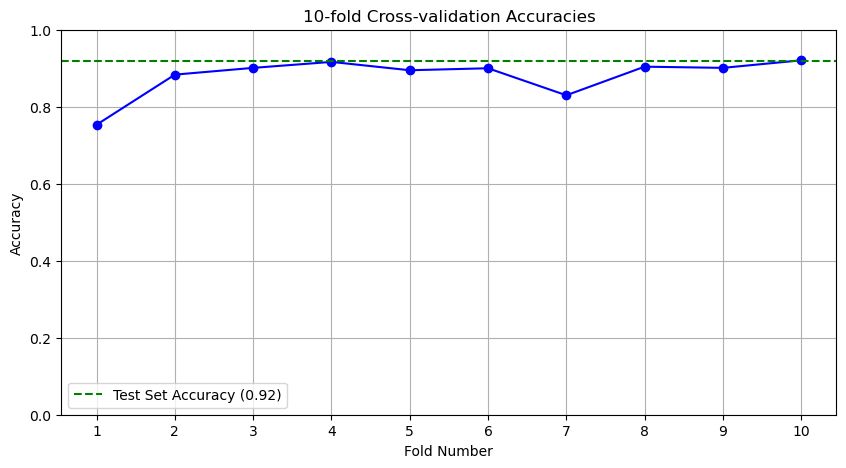

Accuracy on unseen data: 91.88%
Mean CV Accuracy: 88.04%


In [25]:

# Calculating mean and standard deviation for the 10-fold cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

# Plotting the 10-fold cross-validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', color='blue')
plt.title('10-fold Cross-validation Accuracies')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming the accuracy is high, set the y-axis to start from 0.9 for better visualization
plt.xticks(range(1, 11))
plt.grid(True)

# Adding a horizontal line for the test accuracy
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Set Accuracy ({test_accuracy:.2f})')
plt.legend()

plt.show()

# Print the test set accuracy and mean CV accuracy
print(f"Accuracy on unseen data: {test_accuracy:.2%}")

print(f"Mean CV Accuracy: {cv_mean:.2%}")




The average accuracy across the 10-fold cross-validation on the training set is approximately 88%
The accuracy on the test set is 92%.

These high accuracies suggest that the linear classifier is performing very well on both the training and the test data. This could indicate that the data set is likely linearly separable, meaning that a linear decision boundary is sufficient to separate the classes with high accuracy. 

The fact that the model's performance on the unseen test data is close to its performance on the training data also suggests that the model generalizes well to new data




### Trying to draw a decioson boundry to clarify the above finding  - using just class 1 and class 2 

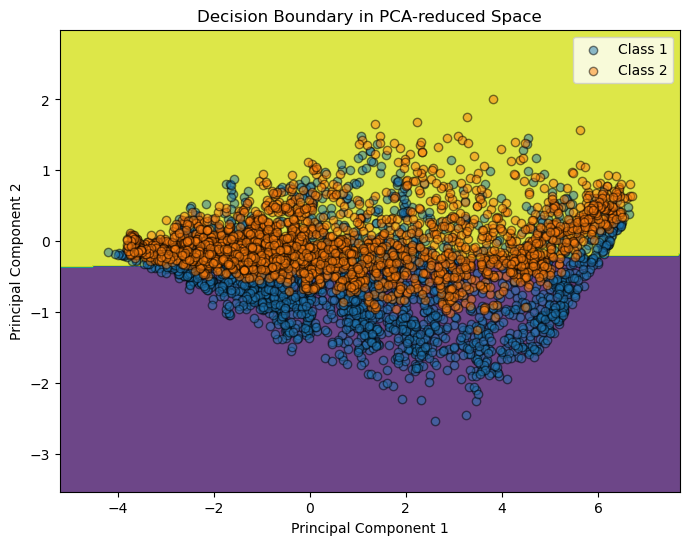

In [57]:
#X_reduced_rf and X_test_all_rf are already normalised!

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

if isinstance(y, pd.DataFrame):
    y = y.squeeze()  # Convert to Series if it's a DataFrame
elif isinstance(y, np.ndarray) and y_train.ndim == 2:
    y = y.ravel()  # Convert to 1D array if it's a 2D numpy array

# Apply PCA and reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reduced_rf)

# Select only two classes (class 1 and class 2)
classes_to_keep = [1, 2]
idx = np.isin(y, classes_to_keep)
X_pca_filtered = X_pca[idx]
y_filtered = y[idx]

# Train the logistic regression model
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1100, random_state=42)

clf.fit(X_pca_filtered, y_filtered)

# Create a mesh to plot the decision boundary
x_min, x_max = X_pca_filtered[:, 0].min() - 1, X_pca_filtered[:, 0].max() + 1
y_min, y_max = X_pca_filtered[:, 1].min() - 1, X_pca_filtered[:, 1].max() + 1
h = 0.02  # Step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict class for each point in the mesh
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8)

# Plot each class separately to add legends
for class_value in np.unique(y_filtered):
    plt.scatter(X_pca_filtered[y_filtered == class_value, 0],
                X_pca_filtered[y_filtered == class_value, 1],
                alpha=0.5,  # Adjust opacity here
                edgecolors='k',
                label=f'Class {class_value}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Decision Boundary in PCA-reduced Space')
plt.legend()  
plt.show()


Conclusion:
Visially looking at it the deciosn boundry isnt able to draw a clear line throught the data points of class1 and class2 though the data says otherwise.


The purpose of the visualization is to  illustrate how the model has learned to separate the two classes based on the training data.
The mesh grid is used to visualize where the model draws the line between class 1 and class 2. 
By overlaying this decision boundary with the actual data points can help visually assess how well the model has learned to separate the two classes.

## MLP Using MLP classifier in Sklearn

In [27]:
#X_reduced_rf and X_test_all_rf are already normalised!


# Define the parameter grid to search for the best parameters

# Softmax is the default output activation function in MLP classifier.
param_grid = {
    'hidden_layer_sizes': [(150,), (200,), (150, 150), (200, 150), (150, 100)], #each ordered pair represents neurons in each layer
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'], # optomizers
    'alpha': [0.0001, 0.001, 0.01], # learning rate
    'learning_rate': ['constant', 'adaptive'],
}

# Initialize the MLPClassifier
#incraesing the iteration to get the model to converge was incraesing the computational time 

mlp = MLPClassifier(max_iter=100) 


# Initialize GridSearchCV to find the best parameters
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3)

# Fit GridSearchCV using the scaled training data
grid_search.fit(X_reduced_rf, y.values.ravel())

# Print out the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_all_rf)
print(classification_report(y_test_all, y_pred))

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parvathyrajan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 150), 'learning_rate': 'constant', 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        60
           1       0.94      0.98      0.96       720
           2       0.98      0.98      0.98       750
           3       0.97      1.00      0.98       450
           4       0.98      0.95      0.97       660
           5       0.78      1.00      0.88        60
           6       0.97      0.87      0.92        90
           7       1.00      0.50      0.67        60
           8       0.97      0.93      0.95       150
           9       0.86      0.82      0.84        90

    accuracy                           0.96      3090
   macro avg       0.93      0.90      0.91      3090
weighted avg       0.96      0.96      0.96      3090



In [28]:

# Print out the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_all_rf)
print(classification_report(y_test_all, y_pred))

Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 150), 'learning_rate': 'constant', 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        60
           1       0.94      0.98      0.96       720
           2       0.98      0.98      0.98       750
           3       0.97      1.00      0.98       450
           4       0.98      0.95      0.97       660
           5       0.78      1.00      0.88        60
           6       0.97      0.87      0.92        90
           7       1.00      0.50      0.67        60
           8       0.97      0.93      0.95       150
           9       0.86      0.82      0.84        90

    accuracy                           0.96      3090
   macro avg       0.93      0.90      0.91      3090
weighted avg       0.96      0.96      0.96      3090



Incraesing the number of iteration to get the model to converge and also experimenting with different combination of neurons was computionally exhaustive using Gridsearch and MLP classifier in Sklearn. It wasnt effective for the comoplex dataset we have. 

Hence we decided to implement Tensor flow.The Keras Tuner tends to be more efficient than Grid Search for complex models and large hyperparameter spaces due to its smarter search algorithms and early-stopping capabilities.

## MLP Using Tensor Flow 

In [197]:
#!conda install tensorflow -y


### Using Keras Tuner - To Find the Best Hyperparameter Set


In [82]:
#pip install keras-tuner


#### Hyerparameter Tuning


In [73]:
# Split your data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_reduced_rf, y, test_size=0.2, stratify=y, random_state=42)

# One hot encode the dataset
y_train_rf = to_categorical(y_train_rf, num_classes=10)
y_test_rf = to_categorical(y_test_rf, num_classes=10)

n_features = X_train_rf.shape[1]



def build_model(hp):
    model = Sequential()
    # Tunable first hidden layer with variable activation function
    model.add(Dense(units=hp.Int('units', min_value=n_features, max_value=n_features*2, step=n_features//2),
                    activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                    input_shape=(n_features,)))
    for i in range(hp.Int('num_layers', 1, 3)):  # Adding 1-3 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                        activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(10, activation='softmax'))  # Output layer with 10 units for 10 classes
    model.compile(optimizer=legacy.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Perform the hyperparameter search
tuner.search(X_train_rf, y_train_rf,
             epochs=30,
             validation_data=(X_test_rf, y_test_rf))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



# Build the model with the best hp
model = build_model(best_hps)

# Train the model
history = model.fit(X_train_rf, y_train_rf, epochs=30, validation_data=(X_test_rf, y_test_rf))



Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Epoch 1/30
243/243 [==============================] - 1s 1ms/step - loss: 1.0894 - accuracy: 0.6622 - val_loss: 0.7095 - val_accuracy: 0.7817
Epoch 2/30
243/243 [==============================] - 0s 1ms/step - loss: 0.4958 - accuracy: 0.8532 - val_loss: 0.5276 - val_accuracy: 0.8297
Epoch 3/30
243/243 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.8882 - val_loss: 0.2901 - val_accuracy: 0.9076
Epoch 4/30
243/243 [==============================] - 0s 974us/step - loss: 0.2972 - accuracy: 0.9045 - val_loss: 0.2412 - val_accuracy: 0.9288
Epoch 5/30
243/243 [==============================] - 0s 967us/step - loss: 0.2612 - accuracy: 0.9162 - val_loss: 0.2120 - val_accuracy: 0.9303
Epoch 6/30
243/243 [==============================] - 0s 998us/step - loss: 0.2220 - accuracy: 0.9280 - val_loss: 0.2796 - val_accuracy: 0.9102
Epoch 7/30
243/243 [==============================] - 0s 983us/step - loss: 0.1942 - accur

In [72]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"The best number of units in the first densely-connected layer: {best_hps.get('units')}")
for i in range(best_hps.get('num_layers')):
    print(f"The best number of units in the densely-connected layer {i+1}: {best_hps.get(f'units_{i}')}")
print(f"The best learning rate for the optimizer: {best_hps.get('learning_rate')}")
print(f"The best learning rate for the optimizer: {best_hps.get('activation')}")



The best number of units in the first densely-connected layer: 300
The best number of units in the densely-connected layer 1: 256
The best number of units in the densely-connected layer 2: 32
The best learning rate for the optimizer: 0.0016124465281378271
The best learning rate for the optimizer: relu


### Using the Optimal Hyper - Parameters from above test with Early Stopping 

In [94]:

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_reduced_rf, y, test_size=0.2, stratify=y, random_state=42)

#One hot encode the dataset
y_train_rf = to_categorical(y_train_rf.values.ravel(), num_classes=10)
y_test_rf = to_categorical(y_test_rf.values.ravel(), num_classes=10)

n_features = X_train_rf.shape[1]



# Define the MLP model architecture
model = Sequential()
model.add(Dense(units= 300, activation='relu'))  
model.add(Dense(units= 256, activation='relu'))
model.add(Dense(units= 32, activation='relu'))
model.add(Dense(10, activation='softmax')) # Output layer with 10 units for 10 classes and softmax activation


model.compile(optimizer=legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




# Set up the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Add the callback to the fit function
history = model.fit(
    X_train_rf, y_train_rf, 
    epochs=50, 
    validation_data=(X_test_rf, y_test_rf),
    callbacks=[early_stopping]
)

Epoch 1/50
243/243 [==============================] - 0s 1ms/step - loss: 1.1502 - accuracy: 0.6357 - val_loss: 0.6591 - val_accuracy: 0.7833
Epoch 2/50
243/243 [==============================] - 0s 1ms/step - loss: 0.5439 - accuracy: 0.8337 - val_loss: 0.4258 - val_accuracy: 0.8824
Epoch 3/50
243/243 [==============================] - 0s 960us/step - loss: 0.3814 - accuracy: 0.8887 - val_loss: 0.3556 - val_accuracy: 0.8927
Epoch 4/50
243/243 [==============================] - 0s 968us/step - loss: 0.3243 - accuracy: 0.8976 - val_loss: 0.2982 - val_accuracy: 0.8983
Epoch 5/50
243/243 [==============================] - 0s 971us/step - loss: 0.2755 - accuracy: 0.9167 - val_loss: 0.2601 - val_accuracy: 0.9252
Epoch 6/50
243/243 [==============================] - 0s 970us/step - loss: 0.2314 - accuracy: 0.9301 - val_loss: 0.2136 - val_accuracy: 0.9303
Epoch 7/50
243/243 [==============================] - 0s 939us/step - loss: 0.2041 - accuracy: 0.9343 - val_loss: 0.1697 - val_accuracy: 0.9

In [95]:
# Preprocess y_test_all if necessary
y_test_all_encoded = to_categorical(y_test_all.values.ravel(), num_classes=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_all_rf, y_test_all_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


97/97 [==============================] - 0s 445us/step - loss: 0.4306 - accuracy: 0.9570
Test Loss: 0.4305572807788849
Test Accuracy: 0.9569579362869263


In [96]:
# Make predictions on the test set
y_pred_probabilities = model.predict(X_test_all_rf)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Generate the classification report

report = classification_report(y_test_all, y_pred_labels, target_names=['Class 1', 'Class 2', 'Class 3','Class 4'
                                                                        ,'Class 5','Class 6','Class 7', 'Class 8'
                                                                       ,'Class 9','Class 10'])
print(report)

97/97 [==============================] - 0s 390us/step
              precision    recall  f1-score   support

     Class 1       0.93      0.95      0.94        60
     Class 2       0.89      0.99      0.94       720
     Class 3       0.99      0.96      0.98       750
     Class 4       0.98      0.99      0.99       450
     Class 5       1.00      0.93      0.96       660
     Class 6       1.00      1.00      1.00        60
     Class 7       0.95      0.92      0.94        90
     Class 8       1.00      0.50      0.67        60
     Class 9       0.95      0.95      0.95       150
    Class 10       0.93      0.93      0.93        90

    accuracy                           0.96      3090
   macro avg       0.96      0.91      0.93      3090
weighted avg       0.96      0.96      0.96      3090



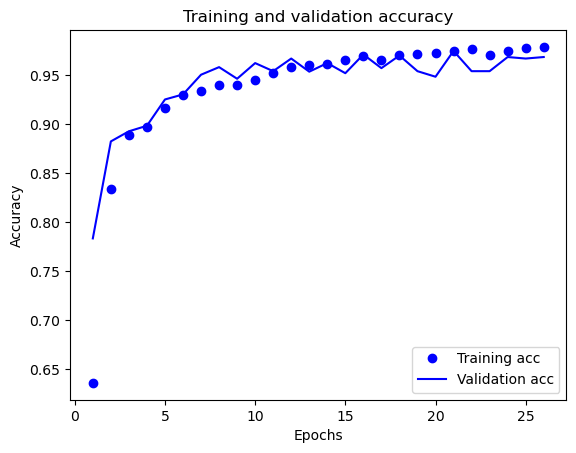

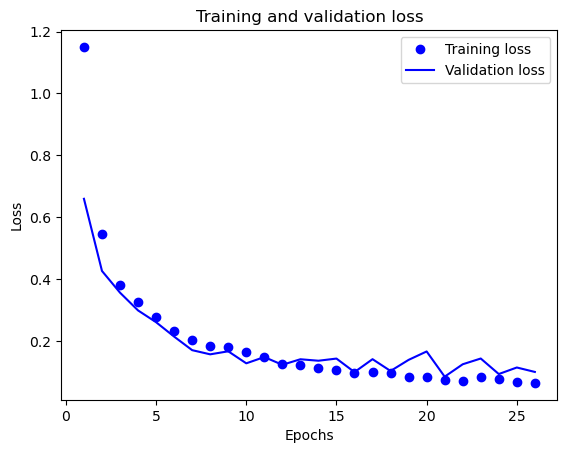

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

# Plot training & validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and Validation Accuracy:
The accuracy graph shows that the model's training accuracy improves rapidly and then plateaus
The validation accuracy also improves and follows the training accuracy closely indicating that the model is generalizing well to the unseen data.

Training and Validation Loss:
The loss graph shows a rapid decrease in training loss which then stabalises with more epochs which means the model is learning better with increasing epochs.
The validation loss decreases alongside the training loss and remains close in value, which also suggests that the model is generalizing well.


### Trying Dropout Decreased the test accuracy of the model

In [92]:

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_reduced_rf, y, test_size=0.2, stratify=y, random_state=42)

#One hot encode the dataset
y_train_rf = to_categorical(y_train_rf.values.ravel(), num_classes=10)
y_test_rf = to_categorical(y_test_rf.values.ravel(), num_classes=10)

n_features = X_train_rf.shape[1]

#Define the MLP model architecture
model = Sequential()
model.add(Dense(units=300, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))  # Another dropout layer

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))  # Another dropout layer



model.add(Dense(10, activation='softmax'))

model.compile(optimizer=legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train_rf, y_train_rf, epochs=50, validation_data=(X_test_rf, y_test_rf))

Epoch 1/50
243/243 [==============================] - 0s 1ms/step - loss: 1.8128 - accuracy: 0.3255 - val_loss: 1.1129 - val_accuracy: 0.6832
Epoch 2/50
243/243 [==============================] - 0s 1ms/step - loss: 1.1829 - accuracy: 0.6103 - val_loss: 0.7392 - val_accuracy: 0.7833
Epoch 3/50
243/243 [==============================] - 0s 1ms/step - loss: 0.9547 - accuracy: 0.6832 - val_loss: 0.5840 - val_accuracy: 0.8060
Epoch 4/50
243/243 [==============================] - 0s 1ms/step - loss: 0.8247 - accuracy: 0.7297 - val_loss: 0.6498 - val_accuracy: 0.7735
Epoch 5/50
243/243 [==============================] - 0s 1ms/step - loss: 0.7680 - accuracy: 0.7451 - val_loss: 0.4698 - val_accuracy: 0.8359
Epoch 6/50
243/243 [==============================] - 0s 1ms/step - loss: 0.7154 - accuracy: 0.7634 - val_loss: 0.4092 - val_accuracy: 0.8622
Epoch 7/50
243/243 [==============================] - 0s 1ms/step - loss: 0.6739 - accuracy: 0.7724 - val_loss: 0.4316 - val_accuracy: 0.8416
Epoch 

In [93]:

y_test_all_encoded = to_categorical(y_test_all.values.ravel(), num_classes=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_all_rf, y_test_all_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

97/97 [==============================] - 0s 464us/step - loss: 0.7321 - accuracy: 0.9061
Test Loss: 0.7320660352706909
Test Accuracy: 0.9061488509178162


### Impact of Model Using Different Activation Layers

In [46]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_reduced_rf, y, test_size=0.2, stratify=y, random_state=42)
y_train_rf = to_categorical(y_train_rf.values.ravel(), num_classes=10)
y_test_rf = to_categorical(y_test_rf.values.ravel(), num_classes=10)
n_features = X_train_rf.shape[1]

def build_and_train_model(activation):
    model = Sequential([
        Dense(units=300, activation=activation, input_shape=(n_features,)),
        Dense(units=256, activation=activation),
        Dense(units=32, activation=activation),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    
    history = model.fit(X_train_rf, y_train_rf, epochs=50, validation_data=(X_test_rf, y_test_rf), callbacks=[early_stopping])
    return history

activations = ['relu', 'tanh', 'sigmoid','LeakyReLU','softmax']
histories = {}

for act in activations:
    print(f"Training model with {act} activation")
    histories[act] = build_and_train_model(act)



Training model with relu activation
Epoch 1/50
243/243 [==============================] - 0s 1ms/step - loss: 1.0922 - accuracy: 0.6692 - val_loss: 0.5807 - val_accuracy: 0.8271
Epoch 2/50
243/243 [==============================] - 0s 1ms/step - loss: 0.5011 - accuracy: 0.8458 - val_loss: 0.3689 - val_accuracy: 0.8844
Epoch 3/50
243/243 [==============================] - 0s 1ms/step - loss: 0.3783 - accuracy: 0.8871 - val_loss: 0.3376 - val_accuracy: 0.8911
Epoch 4/50
243/243 [==============================] - 0s 999us/step - loss: 0.3336 - accuracy: 0.8995 - val_loss: 0.3151 - val_accuracy: 0.8880
Epoch 5/50
243/243 [==============================] - 0s 1ms/step - loss: 0.2698 - accuracy: 0.9199 - val_loss: 0.2928 - val_accuracy: 0.9149
Epoch 6/50
243/243 [==============================] - 0s 982us/step - loss: 0.2424 - accuracy: 0.9235 - val_loss: 0.2065 - val_accuracy: 0.9376
Epoch 7/50
243/243 [==============================] - 0s 983us/step - loss: 0.2090 - accuracy: 0.9350 - val_

243/243 [==============================] - 0s 998us/step - loss: 0.0548 - accuracy: 0.9819 - val_loss: 0.1022 - val_accuracy: 0.9644
Epoch 29/50
243/243 [==============================] - 0s 1ms/step - loss: 0.0548 - accuracy: 0.9819 - val_loss: 0.0869 - val_accuracy: 0.9752
Epoch 30/50
243/243 [==============================] - 0s 996us/step - loss: 0.0464 - accuracy: 0.9846 - val_loss: 0.1257 - val_accuracy: 0.9680
Epoch 31/50
243/243 [==============================] - 0s 990us/step - loss: 0.0656 - accuracy: 0.9787 - val_loss: 0.0880 - val_accuracy: 0.9721
Epoch 32/50
243/243 [==============================] - 0s 995us/step - loss: 0.0576 - accuracy: 0.9810 - val_loss: 0.0655 - val_accuracy: 0.9814
Epoch 33/50
243/243 [==============================] - 0s 994us/step - loss: 0.0455 - accuracy: 0.9856 - val_loss: 0.0770 - val_accuracy: 0.9768
Epoch 34/50
243/243 [==============================] - 0s 996us/step - loss: 0.0510 - accuracy: 0.9828 - val_loss: 0.1100 - val_accuracy: 0.9706

243/243 [==============================] - 0s 1ms/step - loss: 0.1965 - accuracy: 0.9382 - val_loss: 0.1474 - val_accuracy: 0.9551
Epoch 8/50
243/243 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.9405 - val_loss: 0.1785 - val_accuracy: 0.9324
Epoch 9/50
243/243 [==============================] - 0s 1ms/step - loss: 0.1723 - accuracy: 0.9421 - val_loss: 0.2160 - val_accuracy: 0.9216
Epoch 10/50
243/243 [==============================] - 0s 1ms/step - loss: 0.1628 - accuracy: 0.9423 - val_loss: 0.1422 - val_accuracy: 0.9592
Epoch 11/50
243/243 [==============================] - 0s 1ms/step - loss: 0.1459 - accuracy: 0.9520 - val_loss: 0.1703 - val_accuracy: 0.9479
Epoch 12/50
243/243 [==============================] - 0s 1ms/step - loss: 0.1354 - accuracy: 0.9561 - val_loss: 0.1515 - val_accuracy: 0.9546
Epoch 13/50
243/243 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.9610 - val_loss: 0.1725 - val_accuracy: 0.9458
Epoch 14/50
2

Epoch 29/50
243/243 [==============================] - 0s 1ms/step - loss: 1.3630 - accuracy: 0.3809 - val_loss: 1.3506 - val_accuracy: 0.3989
Epoch 30/50
243/243 [==============================] - 0s 1ms/step - loss: 1.3590 - accuracy: 0.3854 - val_loss: 1.3478 - val_accuracy: 0.4174
Epoch 31/50
243/243 [==============================] - 0s 1ms/step - loss: 1.3540 - accuracy: 0.3901 - val_loss: 1.3365 - val_accuracy: 0.3983
Epoch 32/50
243/243 [==============================] - 0s 1ms/step - loss: 1.3449 - accuracy: 0.3897 - val_loss: 1.3308 - val_accuracy: 0.4112
Epoch 33/50
243/243 [==============================] - 0s 1ms/step - loss: 1.3331 - accuracy: 0.3951 - val_loss: 1.3264 - val_accuracy: 0.3896
Epoch 34/50
243/243 [==============================] - 0s 1ms/step - loss: 1.3135 - accuracy: 0.3923 - val_loss: 1.2975 - val_accuracy: 0.4014
Epoch 35/50
243/243 [==============================] - 0s 1ms/step - loss: 1.2950 - accuracy: 0.3973 - val_loss: 1.2835 - val_accuracy: 0.4412

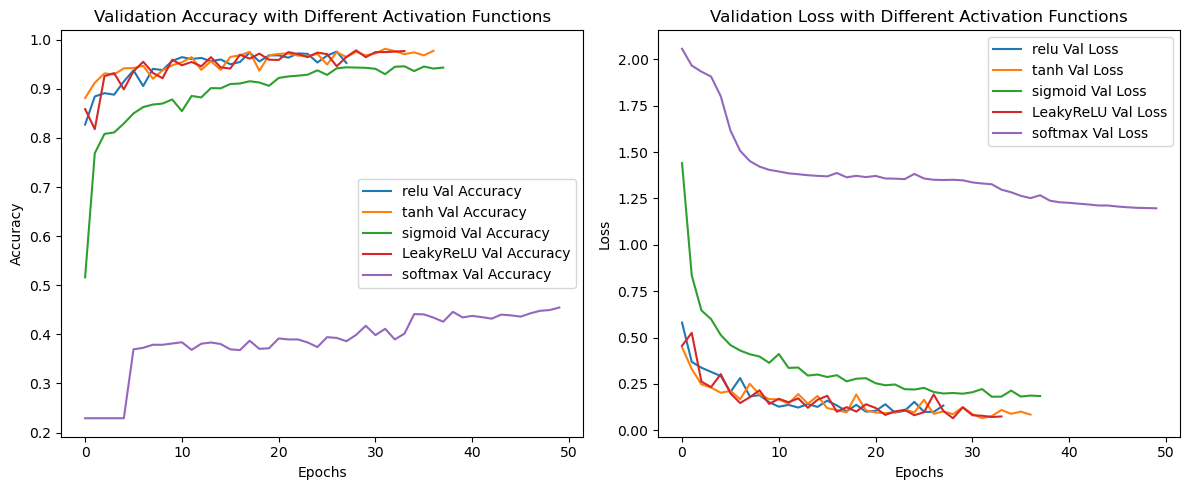

In [47]:

# Plotting the accuracies and losses
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
for act in activations:
    plt.plot(histories[act].history['val_accuracy'], label=f'{act} Val Accuracy')
plt.title('Validation Accuracy with Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
for act in activations:
    plt.plot(histories[act].history['val_loss'], label=f'{act} Val Loss')
plt.title('Validation Loss with Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Let's Run Linear Classifier and MLP  Using Complete DataSet without Feature Selection/ Reduction

In [6]:
## Logistics Regression on The Complete Datasert
X_normalized = X / 255
X_test_all_normalised =  X_test_all / 255

In [7]:
#X_reduced_rf and X_test_all_rf are already normalised!

logistic_regression_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1100, random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(logistic_regression_classifier, X_normalized, y.values.ravel(), cv=10)

# Fit the classifier to the training data
logistic_regression_classifier.fit(X_normalized, y.values.ravel())

# Predict on the test set
y_pred = logistic_regression_classifier.predict(X_test_all)

test_accuracy = accuracy_score(y_test_all, y_pred)

report = classification_report(y_test_all, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.20      0.87      0.33        60
           1       0.81      0.88      0.84       720
           2       0.90      0.92      0.91       750
           3       0.98      0.79      0.87       450
           4       0.97      0.72      0.83       660
           5       0.94      0.48      0.64        60
           6       0.77      0.77      0.77        90
           7       0.73      0.50      0.59        60
           8       1.00      0.59      0.74       150
           9       0.51      1.00      0.67        90

    accuracy                           0.81      3090
   macro avg       0.78      0.75      0.72      3090
weighted avg       0.88      0.81      0.83      3090



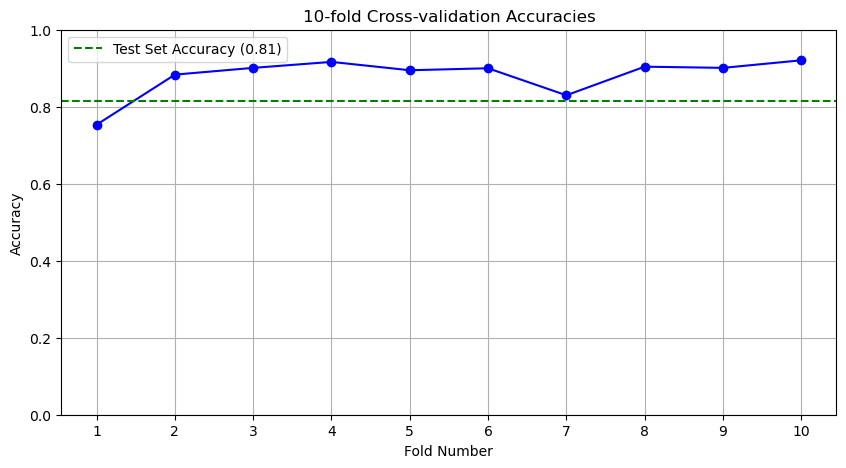

Accuracy on Unseen data/ Test data : 81.36%
Mean CV Accuracy: 88.04%


In [8]:
# Calculating mean and standard deviation for the 10-fold cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

# Plotting the 10-fold cross-validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', color='blue')
plt.title('10-fold Cross-validation Accuracies')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming the accuracy is high, set the y-axis to start from 0.9 for better visualization
plt.xticks(range(1, 11))
plt.grid(True)

# Adding a horizontal line for the test accuracy
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Set Accuracy ({test_accuracy:.2f})')
plt.legend()

plt.show()

# Print the test set accuracy and mean CV accuracy
print(f"Accuracy on Unseen data/ Test data : {test_accuracy:.2%}")

print(f"Mean CV Accuracy: {cv_mean:.2%}")

Accuracies have dropped compafred to when using dataset with feature selection technique implemented.

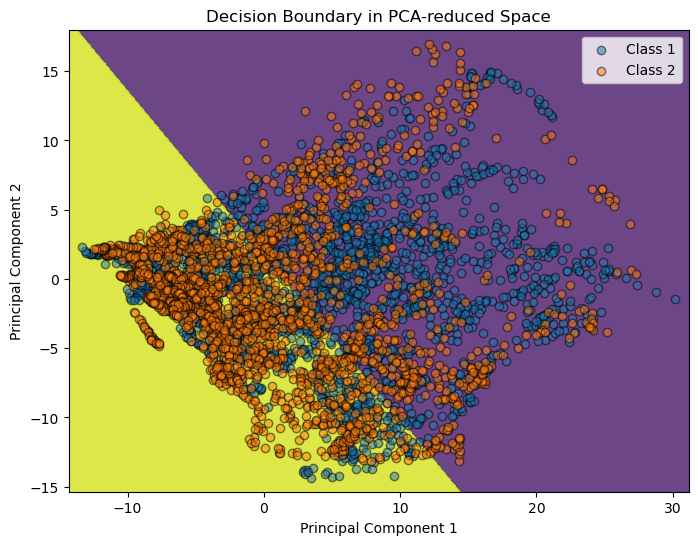

In [10]:
#X_reduced_rf and X_test_all_rf are already normalised!

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

if isinstance(y, pd.DataFrame):
    y = y.squeeze()  # Convert to Series if it's a DataFrame
elif isinstance(y, np.ndarray) and y_train.ndim == 2:
    y = y.ravel()  # Convert to 1D array if it's a 2D numpy array

# Apply PCA and reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Select only two classes (class 1 and class 2)
classes_to_keep = [1, 2]
idx = np.isin(y, classes_to_keep)
X_pca_filtered = X_pca[idx]
y_filtered = y[idx]

# Train the logistic regression model
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1100, random_state=42)

clf.fit(X_pca_filtered, y_filtered)

# Create a mesh to plot the decision boundary
x_min, x_max = X_pca_filtered[:, 0].min() - 1, X_pca_filtered[:, 0].max() + 1
y_min, y_max = X_pca_filtered[:, 1].min() - 1, X_pca_filtered[:, 1].max() + 1
h = 0.02  # Step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict class for each point in the mesh
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8)

# Plot each class separately to add legends
for class_value in np.unique(y_filtered):
    plt.scatter(X_pca_filtered[y_filtered == class_value, 0],
                X_pca_filtered[y_filtered == class_value, 1],
                alpha=0.5,  # Adjust opacity here
                edgecolors='k',
                label=f'Class {class_value}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Decision Boundary in PCA-reduced Space')
plt.legend() 
plt.show()


Conclusion:
When using all the features to draw the decision boundry we can clearly see visually that the data is not lineaerly separable though the evaluation metrics of linear classifier gives high values for f1 score and accuracy


## Tensor Flow - On Complete Dataset

In [11]:
# Split  data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_normalized, y, test_size=0.2, stratify=y, random_state=42)

# One hot encode the dataset
y_train_rf = to_categorical(y_train_rf, num_classes=10)
y_test_rf = to_categorical(y_test_rf, num_classes=10)

n_features = X_train_rf.shape[1]



def build_model(hp):
    model = Sequential()
    # Tunable first hidden layer with variable activation function
    model.add(Dense(units=hp.Int('units', min_value=n_features, max_value=n_features*2, step=n_features//2),
                    activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                    input_shape=(n_features,)))
    for i in range(hp.Int('num_layers', 1, 3)):  # Adding 1-3 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                        activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(10, activation='softmax'))  # Output layer with 10 units for 10 classes
    model.compile(optimizer=legacy.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Perform the hyperparameter search
tuner.search(X_train_rf, y_train_rf,
             epochs=30,
             validation_data=(X_test_rf, y_test_rf))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



# Build the model with the best hp
model = build_model(best_hps)

# Train the model
history = model.fit(X_train_rf, y_train_rf, epochs=30, validation_data=(X_test_rf, y_test_rf))



Trial 30 Complete [00h 00m 22s]
val_accuracy: 0.9169246554374695

Best val_accuracy So Far: 0.9535603523254395
Total elapsed time: 00h 04m 15s
Epoch 1/30
243/243 [==============================] - 2s 8ms/step - loss: 1.4339 - accuracy: 0.5055 - val_loss: 1.0405 - val_accuracy: 0.6662
Epoch 2/30
243/243 [==============================] - 2s 8ms/step - loss: 0.8917 - accuracy: 0.7282 - val_loss: 0.7961 - val_accuracy: 0.7575
Epoch 3/30
243/243 [==============================] - 2s 8ms/step - loss: 0.6528 - accuracy: 0.8135 - val_loss: 0.7149 - val_accuracy: 0.7647
Epoch 4/30
243/243 [==============================] - 2s 8ms/step - loss: 0.5222 - accuracy: 0.8560 - val_loss: 0.5949 - val_accuracy: 0.7962
Epoch 5/30
243/243 [==============================] - 2s 8ms/step - loss: 0.4336 - accuracy: 0.8800 - val_loss: 0.3972 - val_accuracy: 0.8958
Epoch 6/30
243/243 [==============================] - 2s 8ms/step - loss: 0.3821 - accuracy: 0.8950 - val_loss: 0.4389 - val_accuracy: 0.8772
Epoch

In [12]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"The best number of units in the first densely-connected layer: {best_hps.get('units')}")
for i in range(best_hps.get('num_layers')):
    print(f"The best number of units in the densely-connected layer {i+1}: {best_hps.get(f'units_{i}')}")
print(f"The best learning rate for the optimizer: {best_hps.get('learning_rate')}")
print(f"The best learning rate for the optimizer: {best_hps.get('activation')}")



The best number of units in the first densely-connected layer: 3456
The best number of units in the densely-connected layer 1: 96
The best learning rate for the optimizer: 0.00010919635006325875
The best learning rate for the optimizer: relu


In [13]:

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_normalized, y, test_size=0.2, stratify=y, random_state=42)

#One hot encode the dataset
y_train_rf = to_categorical(y_train_rf.values.ravel(), num_classes=10)
y_test_rf = to_categorical(y_test_rf.values.ravel(), num_classes=10)

n_features = X_train_rf.shape[1]



# Define the MLP model architecture
model = Sequential()
model.add(Dense(units= 3456, activation='relu'))  
model.add(Dense(units= 96, activation='relu'))

model.add(Dense(10, activation='softmax')) # Output layer with 10 units for 10 classes and softmax activation


model.compile(optimizer=legacy.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




# Set up the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Add the callback to the fit function
history = model.fit(
    X_train_rf, y_train_rf, 
    epochs=50, 
    validation_data=(X_test_rf, y_test_rf),
    callbacks=[early_stopping]
)

Epoch 1/50
243/243 [==============================] - 2s 8ms/step - loss: 1.5207 - accuracy: 0.4586 - val_loss: 1.3158 - val_accuracy: 0.5222
Epoch 2/50
243/243 [==============================] - 2s 7ms/step - loss: 1.0661 - accuracy: 0.6638 - val_loss: 0.9390 - val_accuracy: 0.7296
Epoch 3/50
243/243 [==============================] - 2s 8ms/step - loss: 0.8336 - accuracy: 0.7629 - val_loss: 0.7301 - val_accuracy: 0.8153
Epoch 4/50
243/243 [==============================] - 2s 7ms/step - loss: 0.6298 - accuracy: 0.8444 - val_loss: 0.7816 - val_accuracy: 0.7131
Epoch 5/50
243/243 [==============================] - 2s 7ms/step - loss: 0.5362 - accuracy: 0.8634 - val_loss: 0.5435 - val_accuracy: 0.8540
Epoch 6/50
243/243 [==============================] - 2s 7ms/step - loss: 0.4680 - accuracy: 0.8787 - val_loss: 0.4544 - val_accuracy: 0.8885
Epoch 7/50
243/243 [==============================] - 2s 7ms/step - loss: 0.3985 - accuracy: 0.8967 - val_loss: 0.4482 - val_accuracy: 0.8627
Epoch 

In [15]:
# Preprocess y_test_all if necessary
y_test_all_encoded = to_categorical(y_test_all.values.ravel(), num_classes=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_all, y_test_all_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


97/97 [==============================] - 0s 2ms/step - loss: 146.9243 - accuracy: 0.8663
Test Loss: 146.92431640625
Test Accuracy: 0.8663430213928223


Overall acc.dropped when using the complete datset without feature reduction.

## CNN Implementation - On complete Dataset

In [ ]:
X_train = pd.read_csv(
    '/Users/ilya/Desktop/Course_work_Data_mining/CompleteDataSet/x_train_all.csv')

X_test = pd.read_csv(
    '/Users/ilya/Desktop/Course_work_Data_mining/CompleteDataSet/x_test_all.csv')

y_train = pd.read_csv(
    "/Users/ilya/Desktop/Course_work_Data_mining/CompleteDataSet/y_train_all.csv")

y_test = pd.read_csv(
    "/Users/ilya/Desktop/Course_work_Data_mining/CompleteDataSet/y_test_all.csv")

In [ ]:
image_height = 48
image_width = 48
num_channels = 1
num_classes = 10
num_epochs = 10
batch_size = 64

In [ ]:
# Reshape X_train to match the expected input shape
X_train_reshaped = np.reshape(
    X_train, (X_train.shape[0], image_height, image_width, num_channels))

# Reshape X_test to match the expected input shape
X_test_reshaped = np.reshape(
    X_test, (X_test.shape[0], image_height, image_width, num_channels))

# Convert y_train to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes)

# Convert y_test to one-hot encoded format
y_test_encoded = to_categorical(y_test, num_classes)

In [ ]:
from keras.layers import Dropout

# Define the CNN model with dropout layers
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Add dropout layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Add dropout layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Add dropout layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train_encoded, epochs=num_epochs, batch_size=batch_size)

Epoch 1/10


2023-11-29 23:47:57.478993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - 6s 37ms/step - loss: 3.2319 - accuracy: 0.2706
Epoch 2/10
152/152 [==============================] - 5s 35ms/step - loss: 1.3149 - accuracy: 0.5112
Epoch 3/10
152/152 [==============================] - 5s 35ms/step - loss: 0.5136 - accuracy: 0.8388
Epoch 4/10
152/152 [==============================] - 5s 31ms/step - loss: 0.2370 - accuracy: 0.9295
Epoch 5/10
152/152 [==============================] - 5s 35ms/step - loss: 0.1836 - accuracy: 0.9492
Epoch 6/10
152/152 [==============================] - 5s 36ms/step - loss: 0.1141 - accuracy: 0.9653
Epoch 7/10
152/152 [==============================] - 6s 36ms/step - loss: 0.1268 - accuracy: 0.9647
Epoch 8/10
152/152 [==============================] - 5s 35ms/step - loss: 0.0890 - accuracy: 0.9745
Epoch 9/10
152/152 [==============================] - 5s 36ms/step - loss: 0.0846 - accuracy: 0.9768
Epoch 10/10
152/152 [==============================] - 6s 37ms/step - loss: 0.0697 - accuracy: 0.9799


In [ ]:
model.evaluate(X_train_reshaped, y_train_encoded)

  5/303 [..............................] - ETA: 4s - loss: 0.0273 - accuracy: 0.9937      

2023-11-29 23:48:52.063050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


303/303 [==============================] - 4s 14ms/step - loss: 0.0116 - accuracy: 0.9975


[0.01163543201982975, 0.9975232481956482]

In [ ]:
model.evaluate(X_test_reshaped, y_test_encoded)

97/97 [==============================] - 1s 14ms/step - loss: 0.0497 - accuracy: 0.9790


[0.04968493804335594, 0.9789643883705139]

### As expected making more sophisticated architecture gives much higher result. Here we got 97.9% accuracy on the test set